# About the Data (from [here](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95))

The Motor Vehicle Collisions crash table contains details on the crash event. Each row represents a crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. The police report (MV104-AN) is required to be filled out for collisions where someone is injured or killed, or where there is at least $1000 worth of damage (https://www.nhtsa.gov/sites/nhtsa.dot.gov/files/documents/ny_overlay_mv-104an_rev05_2004.pdf). It should be noted that the data is preliminary and subject to change when the MV-104AN forms are amended based on revised crash details.For the most accurate, up to date statistics on traffic fatalities, please refer to the NYPD Motor Vehicle Collisions page (updated weekly) or Vision Zero View (updated monthly).


Due to success of the CompStat program, NYPD began to ask how to apply the CompStat principles to other problems. Other than homicides, the fatal incidents with which police have the most contact with the public are fatal traffic collisions. Therefore in April 1998, the Department implemented TrafficStat, which uses the CompStat model to work towards improving traffic safety. Police officers complete form MV-104AN for all vehicle collisions. The MV-104AN is a New York State form that has all of the details of a traffic collision. Before implementing Trafficstat, there was no uniform traffic safety data collection procedure for all of the NYPD precincts. Therefore, the Police Department implemented the Traffic Accident Management System (TAMS) in July 1999 in order to collect traffic data in a uniform method across the City. TAMS required the precincts manually enter a few selected MV-104AN fields to collect very basic intersection traffic crash statistics which included the number of accidents, injuries and fatalities. As the years progressed, there grew a need for additional traffic data so that more detailed analyses could be conducted. The Citywide traffic safety initiative, Vision Zero started in the year 2014. Vision Zero further emphasized the need for the collection of more traffic data in order to work towards the Vision Zero goal, which is to eliminate traffic fatalities. Therefore, the Department in March 2016 replaced the TAMS with the new Finest Online Records Management System (FORMS). FORMS enables the police officers to electronically, using a Department cellphone or computer, enter all of the MV-104AN data fields and stores all of the MV-104AN data fields in the Department’s crime data warehouse. Since all of the MV-104AN data fields are now stored for each traffic collision, detailed traffic safety analyses can be conducted as applicable.


In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from aux import *
import time

t1 = time.time()
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df = df.loc[~df['LOCATION'].isna()]
df = df.loc[~(df['LOCATION'] == '(0.0, 0.0)')]

df['ZIP CODE'] = df['ZIP CODE'].astype(str).replace('     ','nan').astype(float)

df = haversine_KNN_impute(df, 'ZIP CODE')
df = haversine_KNN_impute(df, 'BOROUGH')

df['ZIP CODE'] = df['ZIP CODE'].astype(int)

#Extract the contributing factors and vehicle types.
df = extract_contributing_factors(df)
df = extract_vehicle_types(df)

t2 = time.time()
print(f'Done doing the preprocessing. Time elapsed {t2-t1} seconds.')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Done doing the preprocessing. Time elapsed 197.77184891700745 seconds.


## Why does it happen?

In [10]:
df['CONTRIBUTING FACTORS (GENERAL)']

0                                                  
5                                                  
10                                                 
12                            Physical Surroundings
21                                                 
                             ...                   
1766634                                            
1766635                                            
1766636                                            
1766637                         Physical Disability
1766638    Physical Disability, Physical Disability
Name: CONTRIBUTING FACTORS (GENERAL), Length: 1555782, dtype: object

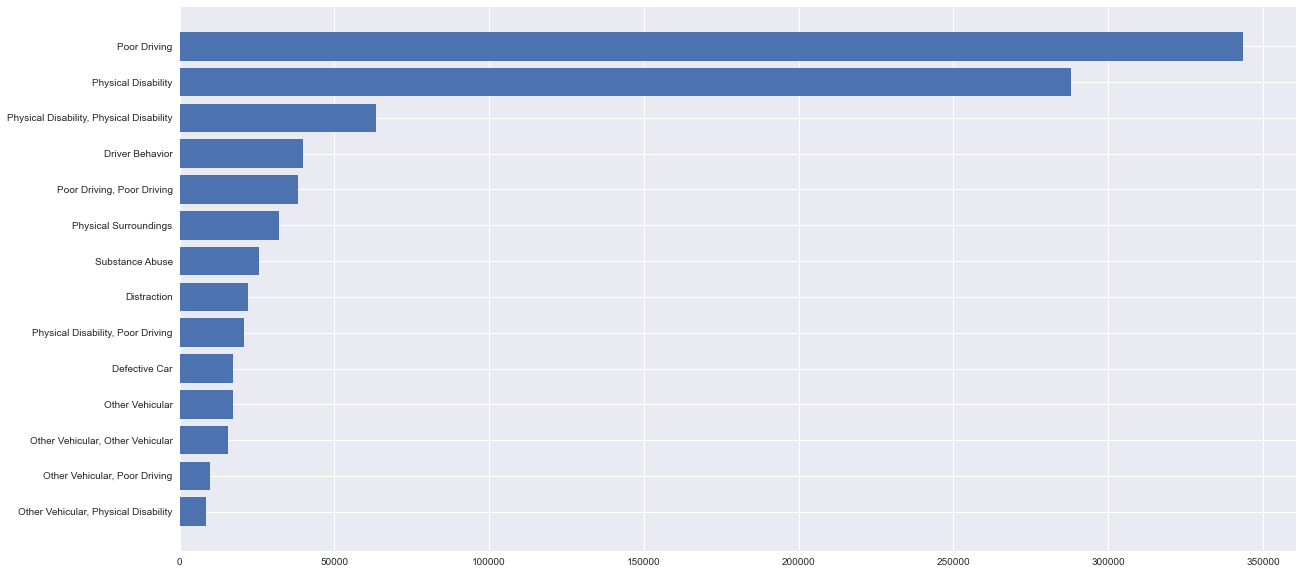

In [14]:
import matplotlib.pyplot as plt
v, c = df.groupby(df['CONTRIBUTING FACTORS (GENERAL)']).size().index, df.groupby(df['CONTRIBUTING FACTORS (GENERAL)']).size().values 
plt.style.use('seaborn')
plt.figure(figsize=(20,10))
plt.barh(v[(-c).argsort()][1:15], c[(-c).argsort()][1:15])
ax = plt.gca()
ax.invert_yaxis()
plt.show()

## Where does it happen?

<BarContainer object of 5 artists>

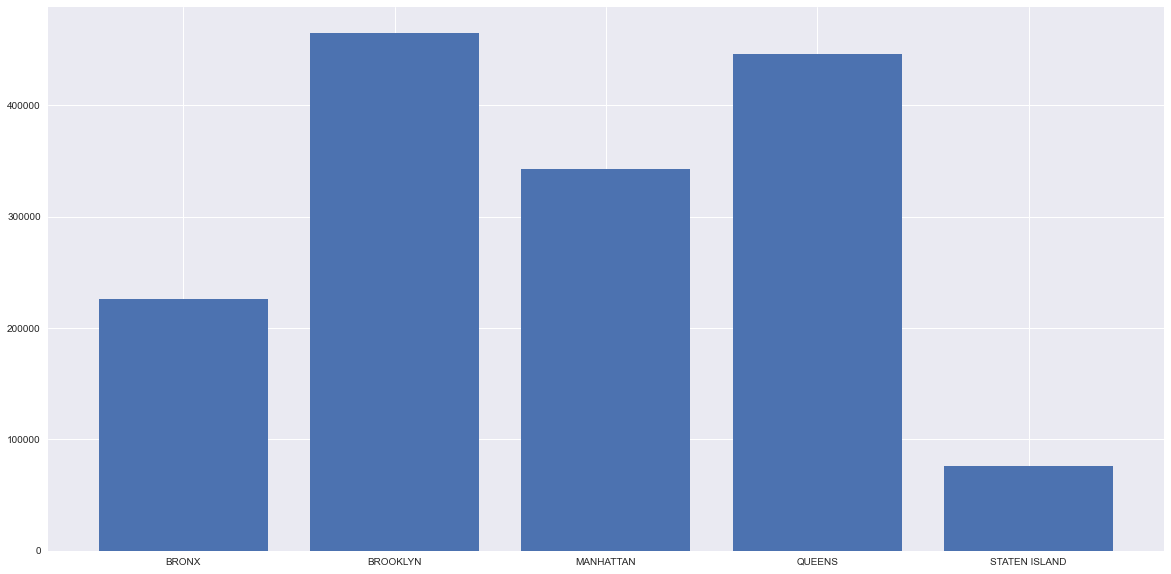

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(list(df.groupby('BOROUGH').size().index), df.groupby('BOROUGH').size().values)

In [5]:
import folium
from folium.plugins import HeatMap

#coords = df.loc[df['Category'] == 'SEX OFFENSES, NON FORCIBLE']['location']\
#            .apply(lambda x : [float(y) for y in x.replace('POINT (','').replace(')','').split(' ')])\
#            .values.tolist()

lat, lon = df[['LATITUDE', 'LONGITUDE']].mean(axis=0)
ny_map = folium.Map([lat, lon],
                    zoom_start = 11.75,
                    tiles = "Stamen Toner")

coords = df[['LATITUDE', 'LONGITUDE']].iloc[:500,:].values.tolist()
# Plot it on the map

#From the documentation:
#radius (int, default 25) – Radius of each “point” of the heatmap
#max_zoom (default 18) – Zoom level where the points reach maximum intensity (as intensity scales with zoom), equals maxZoom of the map by default

HeatMap(coords,radius=15).add_to(ny_map)

#The center of the heatmaps draw a lot of attention. Outliers are harder to spot.
#That being said, when points are stacked, it's hard to see exactly how many there are. 
ny_map

## When does it happen?

In [6]:
df['CRASH TIMESTAMP'] = pd.to_datetime(df['CRASH DATE'] + ' ' + df['CRASH TIME'], format='%m/%d/%Y %H:%M')

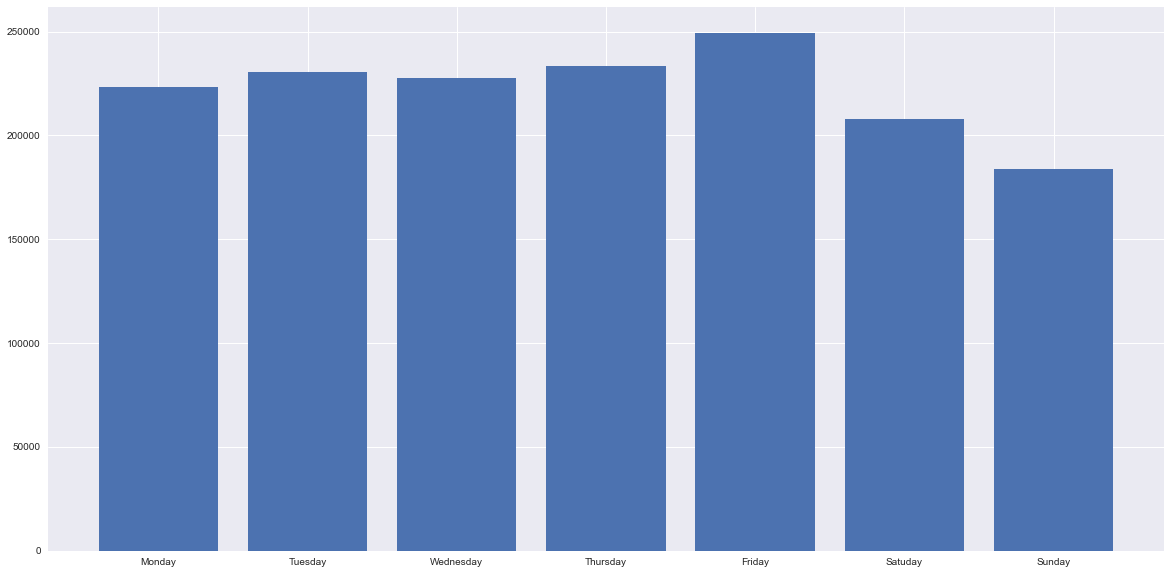

In [7]:
plt.figure(figsize=(20,10))
plt.bar(df.groupby(df['CRASH TIMESTAMP'].dt.weekday).size().index, df.groupby(df['CRASH TIMESTAMP'].dt.weekday).size().values)
plt.xticks(range(0,7), ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Satuday', 'Sunday'])
plt.show()

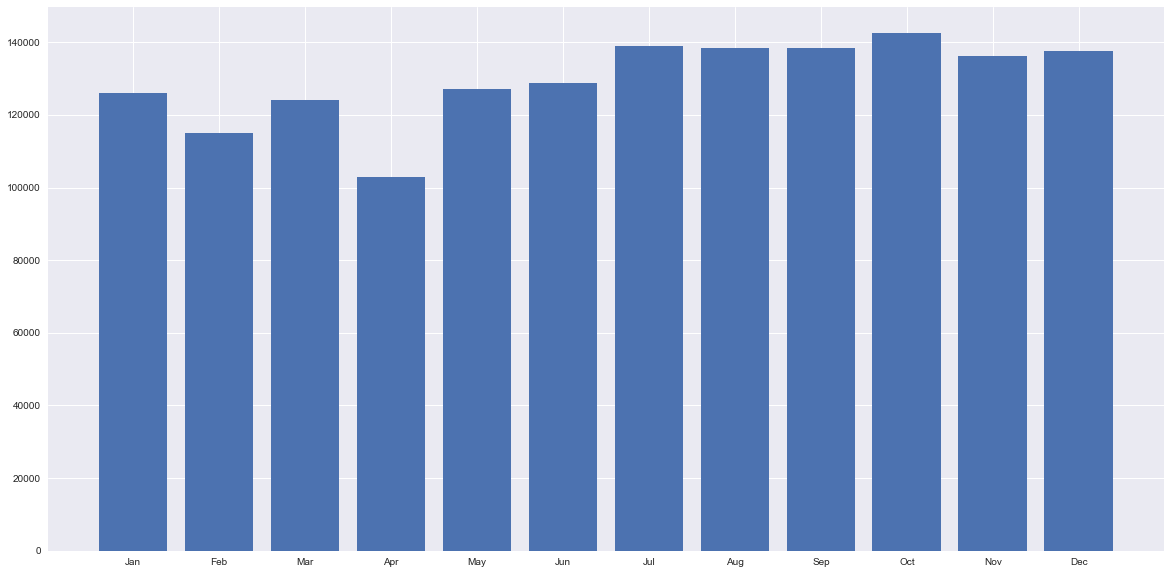

In [8]:
plt.figure(figsize=(20,10))
plt.bar(df.groupby(df['CRASH TIMESTAMP'].dt.month).size().index, df.groupby(df['CRASH TIMESTAMP'].dt.month).size().values)
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

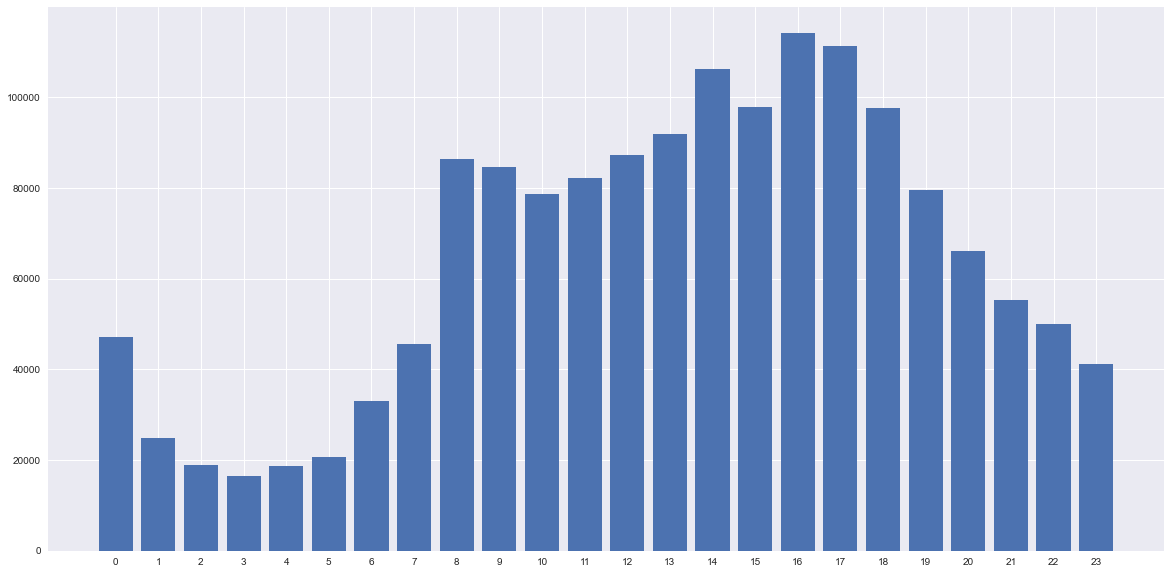

In [9]:
plt.figure(figsize=(20,10))
plt.bar(df.groupby(df['CRASH TIMESTAMP'].dt.hour).size().index, df.groupby(df['CRASH TIMESTAMP'].dt.hour).size().values)
plt.xticks(range(0, 24), range(0, 24))
plt.show()

### Look at the hour for different categories

In [10]:
pd.read_csv('contributing_factors.csv', sep=';')['to'].unique()

array(['unspecified', 'driver inattention/distraction',
       'failure to yield right-of-way', 'following too closely',
       'other vehicular', 'backing unsafely',
       'passing or lane usage improper', 'fatigued/drowsy',
       'turning improperly', 'passing too closely',
       'unsafe lane changing', 'traffic control disregarded',
       'driver inexperience', 'lost consciousness', 'unsafe speed',
       'pavement slippery', 'reaction to uninvolved vehicle',
       'alcohol involvement', 'prescription medication',
       'view obstructed/limited', 'outside car distraction',
       'oversized vehicle', 'physical disability',
       'passenger distraction', 'aggressive driving/road rage',
       'pedestrian/bicyclist/other pedestrian error/confusion',
       'brakes defective', 'fell asleep', 'obstruction/debris', 'glare',
       'failure to keep right', 'other electronic device', 'illness',
       'steering failure', 'pavement defective',
       'tire failure/inadequate', 'react

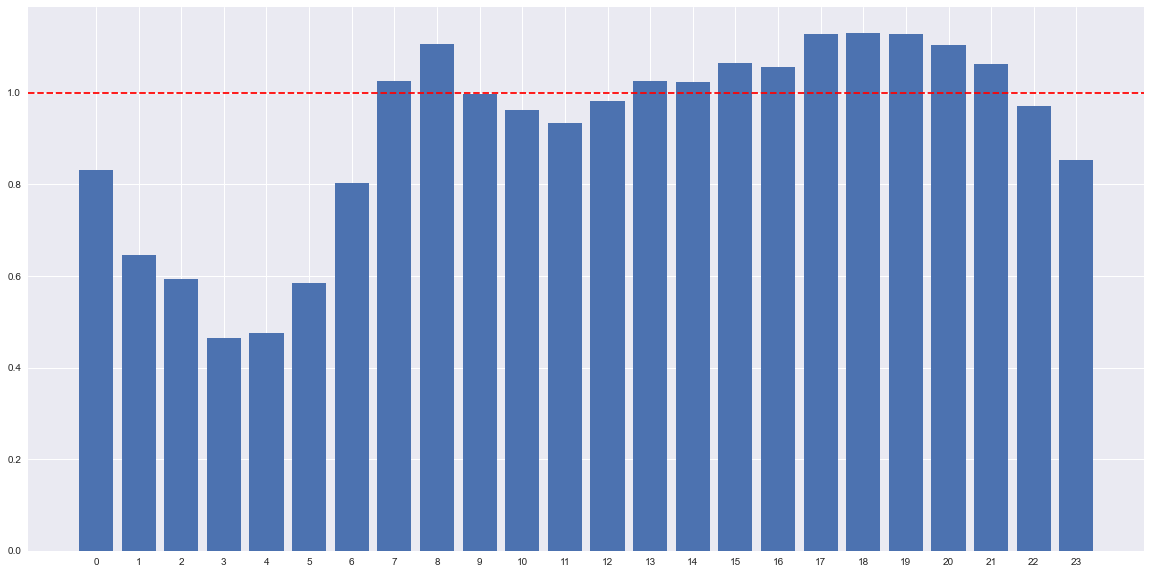

In [11]:
#Baseline distribution.
query_factors = ['right-of-way']
df_query = df.loc[[any(y in x for y in query_factors) for x in df['CONTRIBUTING FACTORS']]]


baseline = df.groupby(df['CRASH TIMESTAMP'].dt.hour).size() / len(df)
query = df_query.groupby(df['CRASH TIMESTAMP'].dt.hour).size() / len(df_query)

plt.figure(figsize=(20,10))
plt.bar(range(0,24), query/baseline)
plt.xticks(range(0,24), range(0,24))
plt.axhline(1, c='r', ls='--')
plt.show()

## Jitter Plot

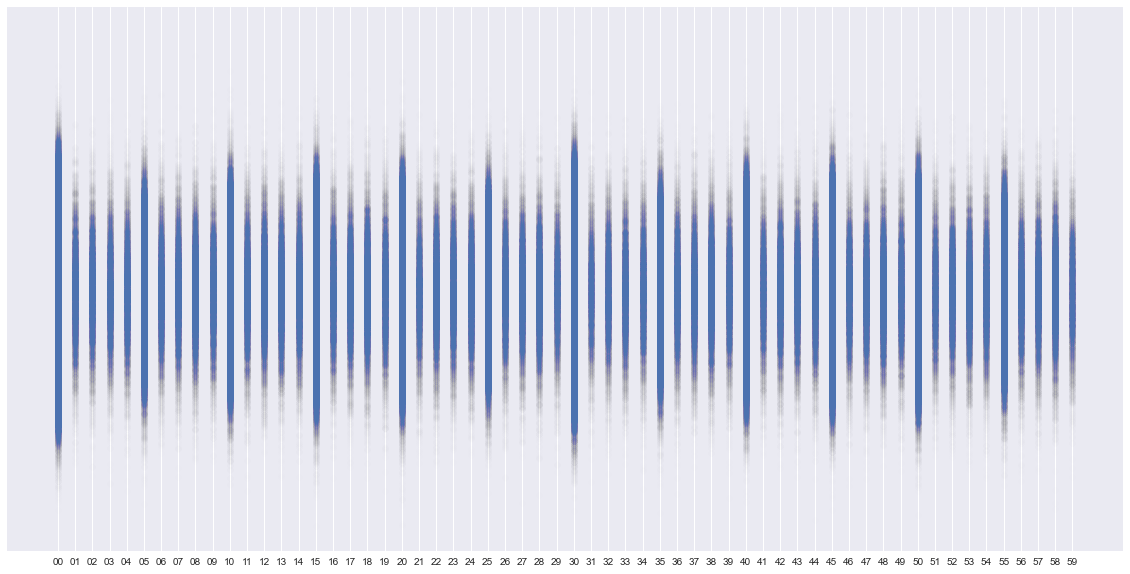

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(df['CRASH TIMESTAMP'].dt.minute, np.random.randn(len(df))+np.ones(len(df)), alpha=.005)
plt.xticks(np.arange(0, 60, 1), [str(x).zfill(2) for x in np.arange(0, 60, 1)])
plt.yticks([])
plt.show()

## When do serious / or lethal crashes occur?

Here, a serious crash is defined as a crash where a person is injured or killed.

In [13]:
df_serious = df.loc[(df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']) > 0]
df_lethal = df.loc[df['NUMBER OF PERSONS KILLED'] > 0]

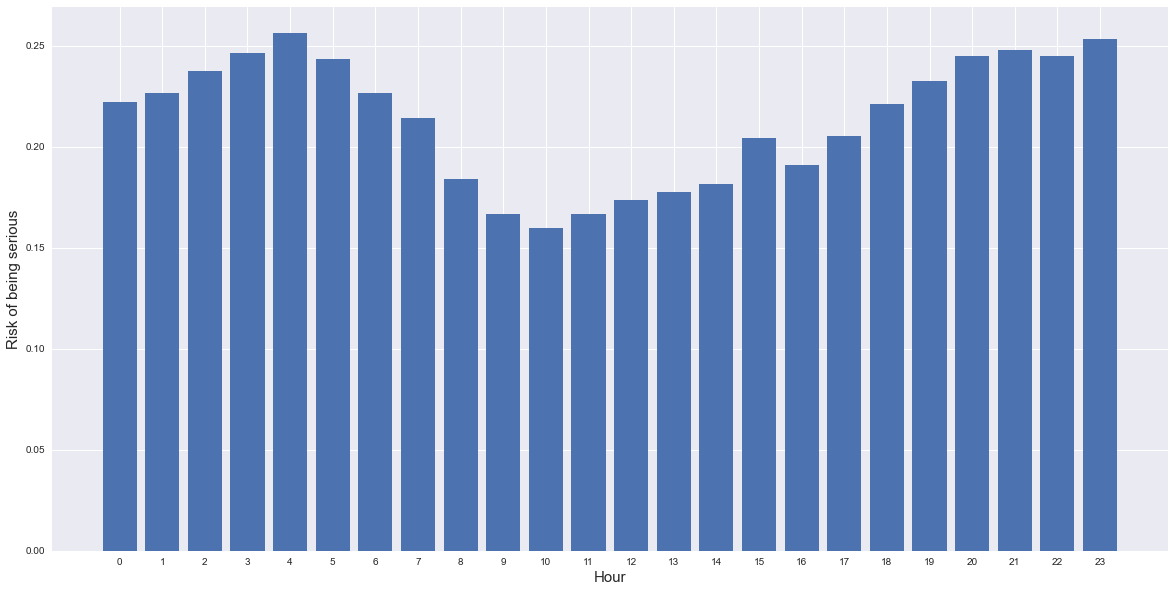

In [14]:
plt.figure(figsize=(20,10))
plt.bar(range(0, 24), df_serious.groupby(df_serious['CRASH TIMESTAMP'].dt.hour).size() / df.groupby(df['CRASH TIMESTAMP'].dt.hour).size())
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Risk of being serious', fontsize=15)
plt.xticks(range(0,24))
plt.show()

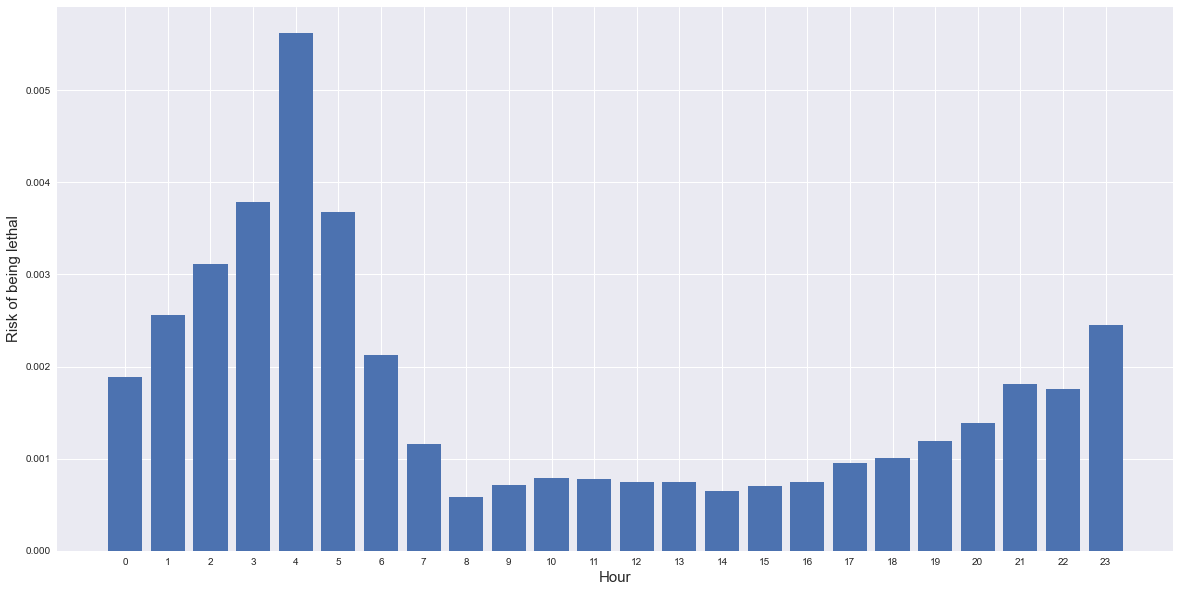

In [15]:
plt.figure(figsize=(20,10))
plt.bar(range(0, 24), df_lethal.groupby(df_lethal['CRASH TIMESTAMP'].dt.hour).size() / df.groupby(df['CRASH TIMESTAMP'].dt.hour).size())
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Risk of being lethal', fontsize=15)
plt.xticks(range(0,24))
plt.show()

In [16]:
df_lethal['CRASH TIMESTAMP'].dt.weekday

667        1
805        2
1165       3
1706       4
1891       1
          ..
1762123    0
1763645    6
1763755    2
1765238    1
1765547    3
Name: CRASH TIMESTAMP, Length: 1851, dtype: int64

### When in the week do serious accidents occur?

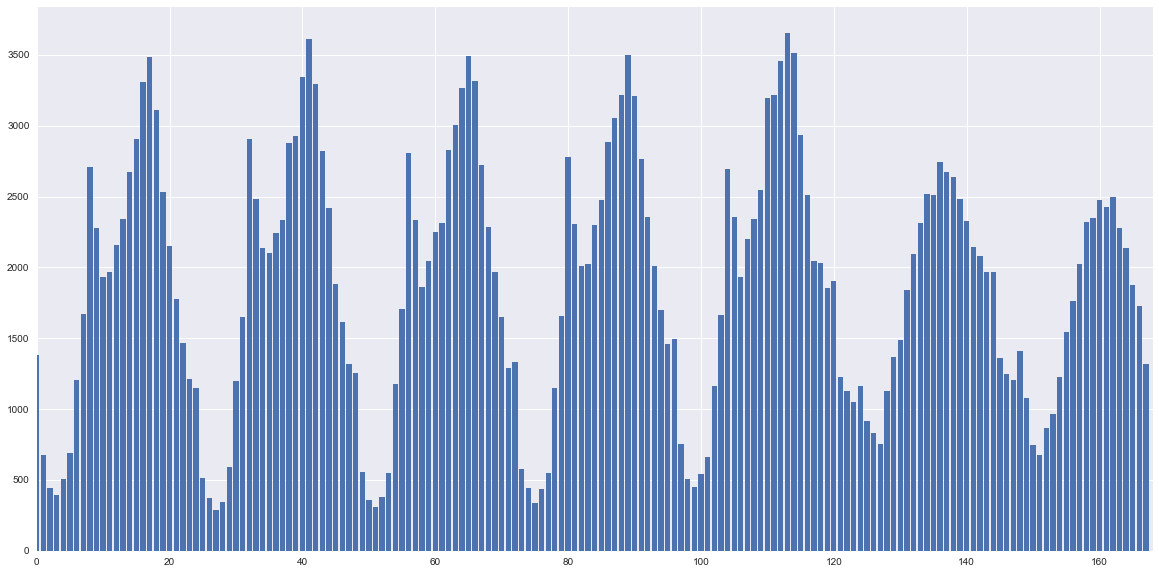

In [17]:
plt.figure(figsize=(20,10))
plt.bar(range(0,24*7), df_serious.groupby([df_serious['CRASH TIMESTAMP'].dt.weekday, df_serious['CRASH TIMESTAMP'].dt.hour]).size()
                                 .unstack().fillna(0).values.reshape(-1,))
plt.xlim(0, 24*7)
plt.show()

## Investigation into injury


In [18]:
injury_columns = [x for x in df.columns if x.startswith('NUMBER OF ')]

for injury in injury_columns:
    print(injury.title())
    n, nocc = df.groupby(injury).size().index, df.groupby(injury).size().values
    for i, j in zip(n, nocc/nocc.sum()):
        print(f'{int(i)}, {j}')
    print('')

Number Of Persons Injured
0, 0.7976347342723777
1, 0.15766959812722478
2, 0.02901464616144073
3, 0.009548993871829054
4, 0.0036027268882338347
5, 0.0014153799478841935
6, 0.0005772076263396938
7, 0.0002577508442786383
8, 0.00011119924204539758
9, 5.334992537438149e-05
10, 4.0494521669711256e-05
11, 2.1211416112705894e-05
12, 1.60692546308378e-05
13, 1.0284322963736192e-05
14, 3.21385092616756e-06
15, 4.499391296634584e-06
16, 4.499391296634584e-06
17, 2.571080740934048e-06
18, 2.571080740934048e-06
19, 1.928310555700536e-06
20, 1.285540370467024e-06
22, 1.928310555700536e-06
24, 1.928310555700536e-06
27, 6.42770185233512e-07
32, 6.42770185233512e-07
43, 6.42770185233512e-07

Number Of Persons Killed
0, 0.9988102232100962
1, 0.0011531386067463107
2, 2.8282106297010966e-05
3, 5.142201144911085e-06
4, 1.9283254293416567e-06
5, 6.427751431138856e-07
8, 6.427751431138856e-07

Number Of Pedestrians Injured
0, 0.9482208947011856
1, 0.04991509093176293
2, 0.0016409754065800993
3, 0.00017354616

### Check the Latitude and Longtitude

We might have some outliers in latitude and longitude still...

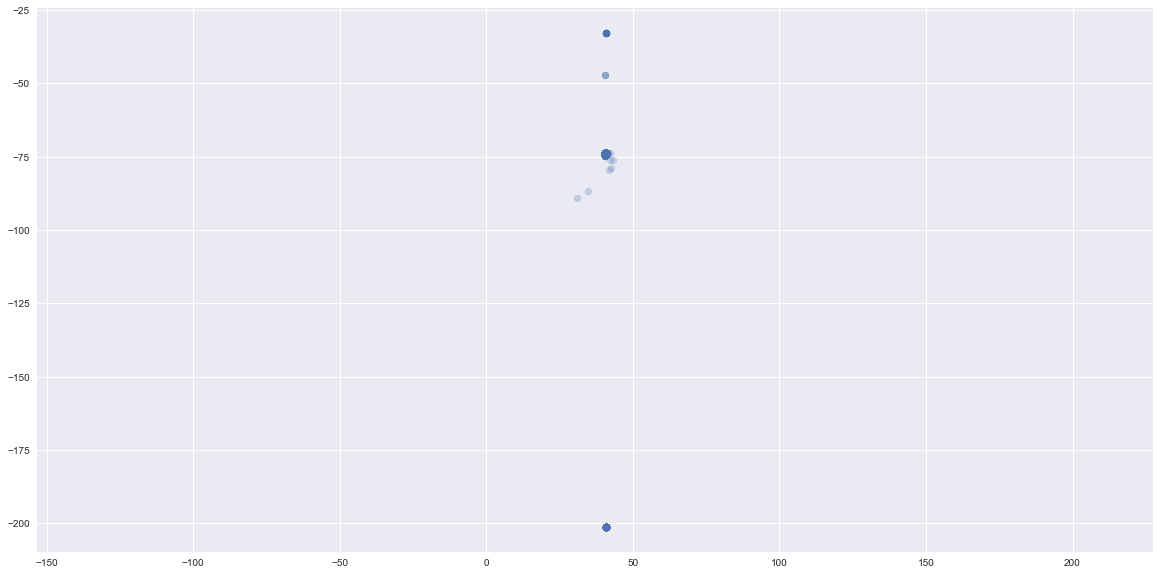

In [19]:
plt.figure(figsize=(20,10))
plt.scatter(df['LATITUDE'], df['LONGITUDE'], alpha=0.25)
plt.axis('equal')
plt.show()

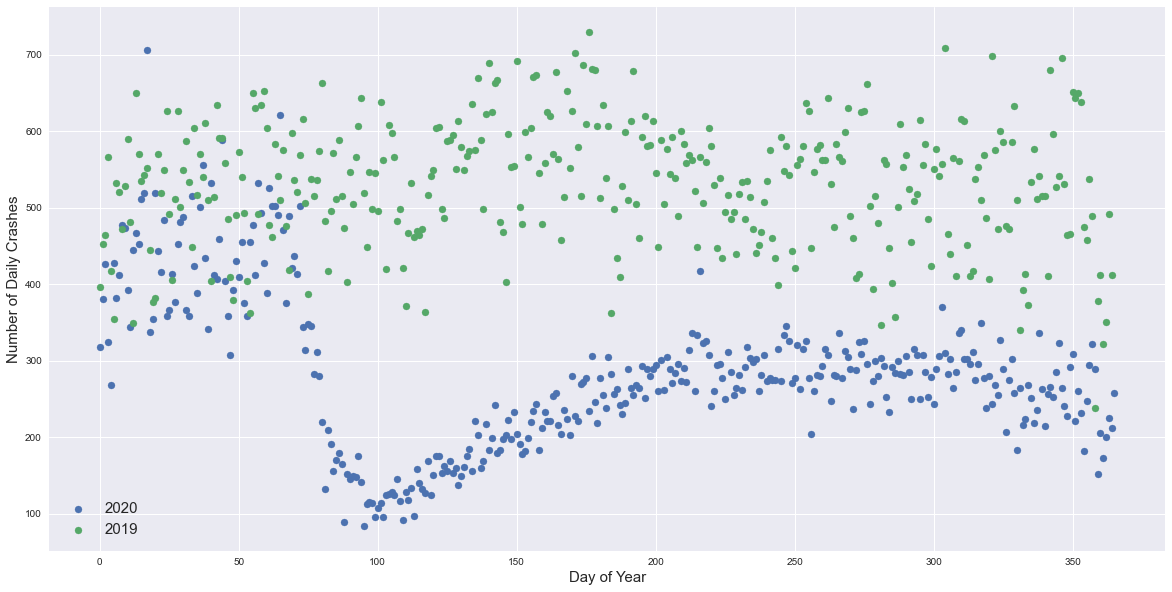

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(range(0, 366), df.loc[df['CRASH TIMESTAMP'].dt.year == 2020].groupby(df['CRASH TIMESTAMP'].dt.date).size().values, label='2020')
plt.scatter(range(0, 365), df.loc[df['CRASH TIMESTAMP'].dt.year == 2019].groupby(df['CRASH TIMESTAMP'].dt.date).size().values, label='2019')
plt.legend(fontsize=15, loc='lower left')
plt.xlabel('Day of Year', fontsize=15)
plt.ylabel('Number of Daily Crashes', fontsize=15)
plt.show()

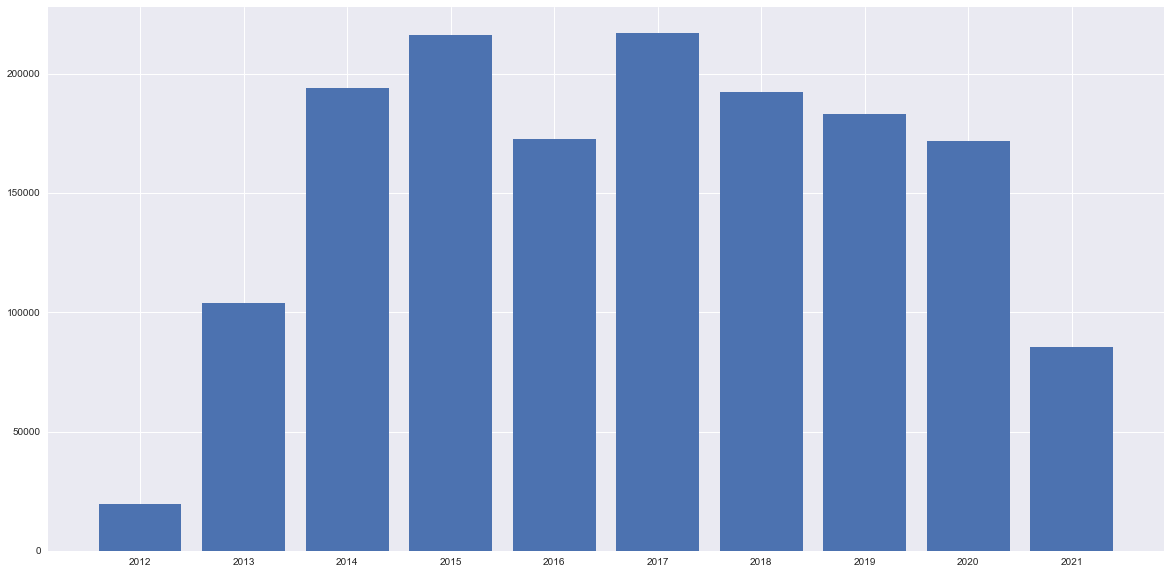

In [21]:
plt.figure(figsize=(20,10))
plt.bar((df['CRASH TIMESTAMP'].dt.year).unique(), df.groupby(df['CRASH TIMESTAMP'].dt.year).size())
plt.xticks((df['CRASH TIMESTAMP'].dt.year).unique())
plt.show()

### Which factors mix?

In [22]:
contributing_factors = np.unique(pd.read_csv('contributing_factors.csv', sep=';')['to'].to_numpy())

In [23]:
contributing_factors

array(['accelerator defective', 'aggressive driving/road rage',
       'alcohol involvement', 'animals action', 'backing unsafely',
       'brakes defective', 'cell phone', 'driver inattention/distraction',
       'driver inexperience', 'driverless/runaway vehicle', 'drugs',
       'eating or drinking', 'failure to keep right',
       'failure to yield right-of-way', 'fatigued/drowsy', 'fell asleep',
       'following too closely', 'glare', 'headlights defective',
       'illness', 'lane marking improper/inadequate',
       'listening/using headphones', 'lost consciousness',
       'obstruction/debris', 'other electronic device',
       'other lighting defects', 'other vehicular',
       'outside car distraction', 'oversized vehicle',
       'passenger distraction', 'passing or lane usage improper',
       'passing too closely', 'pavement defective', 'pavement slippery',
       'pedestrian/bicyclist/other pedestrian error/confusion',
       'physical disability', 'prescription medicati

In [24]:
i, c = df.groupby('CONTRIBUTING FACTORS').size().index, df.groupby('CONTRIBUTING FACTORS').size().values

2042